# Classifier Evaluation

In [107]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.utils import resample
from sklearn.datasets import load_breast_cancer, load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report

## Agenda

- Define cross-entropy loss
- Define a confusion matrix
- Describe different classification metrics such as accuracy, recall, and precision
- Characterize AUC-ROC as a classifier metric

# Motivation

There are many ways to evaluate a classification model, and your choice of evaluation metric can have a major impact on how well your model serves its intended goals. This lecture will review common classification metrics you might consider using, and considerations for how to make your choice.

# Scenario: Identifying Fraudulent Credit Card Transactions

Credit card companies often try to identify whether a transaction is fraudulent at the time when it occurs, in order to decide whether to approve it. Let's build a classification model to try to classify fraudulent transactions! 

The data for this example from from [this Kaggle dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [78]:
# Code to downsample from original dataset
#
# credit_data = pd.read_csv('creditcard.csv')
# credit_data_small = credit_data.iloc[0:10000]
# credit_data_small.describe()
# credit_data_small.to_csv('credit_fraud_small.csv', index=False)

In [79]:
credit_data = pd.read_csv('credit_fraud_small.csv')

The dataset contains features for the transaction amount, the relative time of the transaction, and 28 other features formed using PCA. The target 'Class' is a 1 if the transaction was fraudulent, 0 otherwise

In [97]:
credit_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

Let's see what we can learn from some summary statistics.

In [96]:
credit_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5966.033400,-0.241862,0.281949,0.906270,0.264148,-0.046398,0.133108,-0.071689,-0.064778,0.802224,...,-0.051990,-0.152671,-0.033268,0.021335,0.087146,0.108140,0.005518,0.002915,63.030188,0.00380
std,4473.403739,1.521679,1.308139,1.159154,1.441235,1.182935,1.307311,1.077430,1.259064,1.155198,...,0.913811,0.631083,0.487814,0.594430,0.428171,0.562793,0.410868,0.266247,184.486158,0.06153
min,0.000000,-27.670569,-34.607649,-15.496222,-4.657545,-32.092129,-23.496714,-26.548144,-23.632502,-6.329801,...,-11.468435,-8.527145,-15.144340,-2.512377,-2.577363,-1.338556,-7.976100,-3.509250,0.000000,0.00000
25%,2072.750000,-1.013283,-0.208342,0.412799,-0.614424,-0.643390,-0.629934,-0.542336,-0.190747,0.070868,...,-0.268120,-0.549638,-0.174120,-0.327817,-0.158137,-0.327974,-0.084489,-0.015753,5.000000,0.00000
50%,4563.500000,-0.372799,0.288524,0.944361,0.219861,-0.152769,-0.152566,-0.055585,0.012865,0.805275,...,-0.123273,-0.136746,-0.045794,0.079976,0.121001,0.042865,-0.004568,0.015897,15.950000,0.00000
75%,10233.250000,1.150864,0.901879,1.602903,1.125666,0.371081,0.505357,0.476280,0.274533,1.506299,...,0.032707,0.247490,0.081665,0.410877,0.359058,0.476394,0.120811,0.077182,50.960000,0.00000
max,15012.000000,1.960497,8.636214,4.101716,10.463020,34.099309,21.393069,34.303177,5.060381,10.392889,...,22.588989,4.534454,13.876221,3.200201,5.525093,3.517346,8.254376,4.860769,7712.430000,1.00000


**Question**: What can we learn from the mean of the target 'Class'?

<details>
<summary>Answer</summary>
Fraudulent transactions are rare - only 0.4% of transactions were fraudulent
</details>

## Logistic Regression

Let's run a logistic regression model using all of our features.

In [111]:
# Separate data into feature and target DataFrames
X = credit_data.drop('Class', axis = 1)
y = credit_data['Class']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                   random_state=1)
# Scale the data for modeling
cred_scaler = StandardScaler()
cred_scaler.fit(X_train)
X_train_sc = cred_scaler.transform(X_train)
X_test_sc = cred_scaler.transform(X_test)

# Train a logistic regresssion model with the train data
cred_model = LogisticRegression(random_state=42)
cred_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

## Evaluation

Let's calculate the accuracy score for our model using the test set.

In [112]:
cred_model.score(X_test_sc, y_test)

0.9988

We got 99.88% accuracy, meaning that 99.88% of our predictions were correct! That seems great, right? Maybe... too great? Let's dig in deeper.

## Confusion Matrix

Let's consider the four categories of predictions our model might have made:

* Predicting that a transaction was fraudulent when it actually was (**true positive** or **TP**)
* Predicting that a transaction was fraudulent when it actually wasn't (**false positive** or **FP**)
* Predicting that a transaction wasn't fraudulent when it actually was (**false negative** or **FN**)
* Predicting that a transaction wasn't fraudulent when it actually wasn't (**true negative** or **TN**)

The **confusion matrix** gives us all four of these values.

In [113]:
y_pred = cred_model.predict(X_test_sc)
cm_1 = confusion_matrix(y_test, y_pred)
cm_1

array([[2493,    0],
       [   3,    4]])

Notice the way that sklearn displays its confusion matrix: The rows are \['actually false', 'actually true'\]; the columns are \['predicted false', 'predicted true'\].

So it displays:

$\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}$

**Question:** Do you see anything surprising in the confusion matrix?

## Classification Metrics

Let's calculate some common classification metrics and consider which would be most useful for this scenario.

In [101]:
tn = cm_1[0, 0]
fp = cm_1[0, 1]
fn = cm_1[1, 0]
tp = cm_1[1, 1]

## Accuracy

**Accuracy** = $\frac{TP + TN}{TP + TN + FP + FN}$

In words: How often did my model correctly identify transactions (fraudulent or not fraudulent)? This should give us the same value as we got from the `.score()` method.

In [102]:
acc = (tp + tn) / (tp + tn + fp + fn)
print(acc)

0.9988


## Recall

**Recall** = **Sensitivity** = $\frac{TP}{TP + FN}$

In words: How many of the actually fraudulent transactions did my model identify? 

In [103]:
rec = tp / (tp + fn)
print(rec)

0.5714285714285714


**Question:** Do you think a credit card company would consider recall to be an important metric? Why or why not?

## Precision

**Precision** = **Specificity** = $\frac{TP}{TP + FP}$

In words: How often was my model's prediction of 'fraudulent' correct?

In [104]:
prec = tp / (tp + fp)
print(prec)

1.0


**Question:** Do you think a credit card company would care more about recall or precision?

## F Score

The F score is a combination of precision and recall, which can be useful when both are important for a business problem. Most common is the **F-1 Score**, which is an equal balance of the two using a [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean).

**F-1 Score** = $\frac{2PrRc}{Pr + Rc}$ = $\frac{2TP}{2TP + FP + FN}$

In [105]:
f1_score = 2*prec*rec / (prec + rec)
print(f1_score)

0.7272727272727273


**Question:** Which of these metrics do you think a credit card company would care most about when trying to flag fraudulent transactions to deny?

## `classification_report()`

You can get all of these metrics using the `classification_report()` function. 

- The top rows show statistics for if you treated each label as the "positive" class
- **Support** shows the sample size in each class
- The averages in the bottom two rows are across the rows in the class table above (useful when there are more than two classes)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2493
           1       1.00      0.57      0.73         7

    accuracy                           1.00      2500
   macro avg       1.00      0.79      0.86      2500
weighted avg       1.00      1.00      1.00      2500



# Scenario: Breast Cancer Prediction

Let's evaulate a model using scikit-learn's breast cancer dataset:

In [127]:
# Load the data
preds, target = load_breast_cancer(return_X_y=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(preds, target,
                                                   random_state=42)

# Scale the data
bc_scaler = StandardScaler()
bc_scaler.fit(X_train)
X_train_sc = bc_scaler.transform(X_train)
X_test_sc = bc_scaler.transform(X_test)

# Run the model
bc_model = LogisticRegression(solver='lbfgs', max_iter=10000,
                           random_state=42)
bc_model.fit(X_train_sc, y_train)

LogisticRegression(max_iter=10000, random_state=42)

## Task

Calculate the following for this model:

- Confusion Matrix
- Accuracy
- Precision
- Recall
- F1 Score

Discuss: Which one would you choose to evaluate the model for use as a diagnostic tool to detect breast cancer? Why?

In [128]:
# Your work here

In [129]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
y_pred = bc_model.predict(X_test_sc)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[53  1]
 [ 2 87]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       0.99      0.98      0.98        89

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



# Summary: Which Metric Should I Care About?

Well, it depends.

Accuracy:
- Pro: Takes into account both false positives and false negatives.
- Con: Can be misleadingly high when there is a significant class imbalance. (A lottery-ticket predictor that *always* predicts a loser will be highly accurate.)

Recall:
- Pro: Highly sensitive to false negatives.
- Con: No sensitivity to false positives.

Precision:
- Pro: Highly sensitive to false positives.
- Con: No sensitivity to false negatives.

F-1 Score:
- Harmonic mean of recall and precision.

The nature of your business problem will help you determine which metric matters.

Sometimes false positives are much worse than false negatives: Arguably, a model that compares a sample of crime-scene DNA with the DNA in a city's database of its citizens presents one such case. Here a false positive would mean falsely identifying someone as having been present at a crime scene, whereas a false negative would mean only that we fail to identify someone who really was present at the crime scene as such.

On the other hand, consider a model that inputs X-ray images and predicts the presence of cancer. Here false negatives are surely worse than false positives: A false positive means only that someone without cancer is misdiagnosed as having it, while a false negative means that someone with cancer is misdiagnosed as *not* having it.

# Level Up: Cost Matrix

One might assign different weights to the costs associated with false positives and false negatives. (We'll standardly assume that the costs associated with *true* positives and negatives are negligible.)

**Example**. Suppose we are in the DNA prediction scenario above. Then we might construct the following cost matrix:

In [121]:
cost = np.array([[0, 10], [3, 0]])
cost

array([[ 0, 10],
       [ 3,  0]])

This cost matrix will allow us to compare models if we have access to those models' rates of false positives and false negatives, i.e. if we have access to the models' confusion matrices!

**Problem**. Given the cost matrix above and the confusion matrices below, which model should we go with?

In [122]:
conf1, conf2 = np.array([[100, 10], [30, 300]]), np.array([[120, 20], [0, 300]])

print(conf1, 2*'\n', conf2)

[[100  10]
 [ 30 300]] 

 [[120  20]
 [  0 300]]


# Level Up: Multiple Classes

We can understand these metrics of recall, precision, and the rest even if there are more than two classes in our classification problem.

In [130]:
flowers = load_iris()

In [131]:
print(flowers.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [132]:
dims_train, dims_test, spec_train, spec_test = train_test_split(flowers.data,
                                                                flowers.target,
                                                                test_size=0.5,
                                                               random_state=42)

In [133]:
spec_train[:5]

array([1, 2, 1, 0, 1])

In [134]:
ss_f = StandardScaler()

ss_f.fit(dims_train)

dims_train_sc = ss_f.transform(dims_train)
dims_test_sc = ss_f.transform(dims_test)

In [135]:
logreg_f = LogisticRegression(multi_class='multinomial',
                             C=0.01, random_state=42)

logreg_f.fit(dims_train_sc, spec_train)

LogisticRegression(C=0.01, multi_class='multinomial', random_state=42)

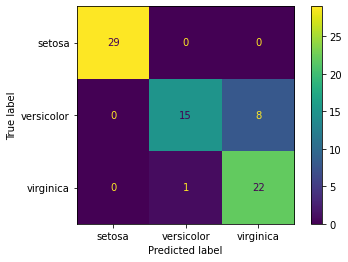

In [136]:
plot_confusion_matrix(estimator=logreg_f,
                      X=dims_test_sc,
                      y_true=spec_test,
                     display_labels=[
                         'setosa',
                         'versicolor',
                         'virginica'
                            ]);

In [144]:
print(classification_report(spec_test,
              logreg_f.predict(dims_test_sc)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.94      0.65      0.77        23
           2       0.73      0.96      0.83        23

    accuracy                           0.88        75
   macro avg       0.89      0.87      0.87        75
weighted avg       0.90      0.88      0.88        75



For each of these metrics, we choose one class to be the "positive" class, and the rest are assigned to the "negative" class.

# BREAK Lecture 2

In [118]:
credit_data = pd.read_csv('credit_fraud_small.csv')

# Separate data into feature and target DataFrames
X = credit_data.drop('Class', axis = 1)
y = credit_data['Class']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                   random_state=1)
# Scale the data for modeling
cred_scaler = StandardScaler()
cred_scaler.fit(X_train)
X_train_sc = cred_scaler.transform(X_train)
X_test_sc = cred_scaler.transform(X_test)

# Train a logistic regresssion model with the train data
cred_model = LogisticRegression(random_state=42)
cred_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

### Predictions

***`.predict()` vs. `.predict_proba()`***

In [110]:
logit_model.predict_proba(X_test_sc)[:5]

array([[9.99949036e-01, 5.09641701e-05],
       [9.99976279e-01, 2.37213738e-05],
       [9.99998007e-01, 1.99332418e-06],
       [9.99994131e-01, 5.86929843e-06],
       [9.99991505e-01, 8.49504830e-06]])

## Strategies

There are a couple of strategies for trying to quantify these important differences in value between false positives and false negatives.

## Adjust the thresholds for false positives and false negatives.

Let's turn to this now!

## The Area Under the Curve of the Receiver Operating Characteristic

### Data

First let's generate some data using sklearn's make_classification tool:

In [ ]:
X, y = make_classification(n_samples=10000, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Model

Now we'll fit a LogisticRegression object:

In [ ]:
logreg = LogisticRegression(solver='liblinear')

logreg.fit(X_train_sc, y_train)

### Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, logreg.predict(X_test_sc))

In [ ]:
cm

Defining true/false positives/negatives:

In [ ]:
tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]

### AUC-ROC

The Receiver Operating Characteristic curve plots the true-positive rate vs. the false-positive rate. Let's define these now:

In [ ]:
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

#### Thresholds

Wait. How does this make sense? Doesn't a classifier just have a certain number of true positives, false positives, and all the rest? And so wouldn't a "plot" of these rates just be a single point on a graph?

Consider a prediction for a particular data point. The features have particular values that lead the model to predict 0 or 1, one way or the other. But the model doesn't merely spit out 0's and 1's: As we just saw, there is a *calculation* done here. Let's look again at the predicted probabilities of class membership for a particular point:

In [ ]:
logreg.predict_proba(X_test_sc)[0]

In [ ]:
logreg.predict(X_test_sc)[0]

Now the default behavior is simply to take the larger of these values as the "real" prediction. Since $0.84 > 0.16$, we'll understand the model to be predicting this point to belong to class "1" (or the positive class). An equivalent way of understanding the default behavior is that we:

- round the predicted numbers up to 1 if they are at least as large as 0.5; and
- round them down to 0 if they are less than 0.5.

Since the probabilities must sum to 1, there will never be any problem with this algorithm.

But we don't have to do things this way. Suppose we're building a model that predicts the presence of prostate cancer from X-ray scans of prostates. And suppose we get a pair of probabilities for some particular scan that look like this:

- pred_neg: 0.52, pred_pos: 0.48

Because false negatives (cancerous prostates mislabeled) are *much* more costly than false positives (non-cancerous prostates mislabeled), we may well want to **adjust our threshold** of classification. We might want to have our model predict "positive" if the corresponding probability is, say, as low as 0.4, or maybe even as low as 0.1. (Speaking for myself, if there was even a 10% chance that my prostate was cancerous, I think I'd probably want to know about it.)

Clearly, the true- and false-positive rates will change if we make this adjustment to the threshold. In fact, in the present case that was the whole point of making the adjustment: We want to minimize our false negatives.

So this is how the plot of these rates takes shape.

Let's build a function that will take in our data, together with a threshold setting, and return the corresponding true- and false-positive rates.

In [ ]:
def classify_rates(X_train, X_test, y_train, y_test, thresh):
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(X_train, y_train)
    y_hat_probs = logreg.predict_proba(X_test)
    y_hat = []
    for val in y_hat_probs:                                 # Each element in y_hat_probs is an array.
        if val[0] < thresh:                                 # We'll set our own threshold for classifying
            y_hat.append(1)                                 # a test point as positive! The lower my threshold,
        else:                                               # the fewer predicted positives I'll have. For the
            y_hat.append(0)                                 # cancer example, I'd want to set a *high* threshold.
    cm = confusion_matrix(y_test, y_hat)
    tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr, f'tpr:{round(tpr, 3)}, fpr:{round(fpr, 3)}'

True- and false-positive rates for various thresholds:

In [ ]:
for x in np.linspace(0, 1, 11):
    print(f'Rates at threshold = {round(x, 1)}: ' + classify_rates(X_train_sc, X_test_sc, y_train, y_test, x)[2])

As my threshold goes up, I'll have more positive predictions, which means I'll have both more true positives and more false positives.

Note:

- I can artificially increase my true-positive rate to 1 by setting my threshold to 1, but at that point my false-positive rate is also 1! I'll have no true negatives and no false negatives. This will arise naturally if my training data has **very few (actual) negatives**. This was the problem in Lottery Scenario 1.
- I can artificially reduce my false-positive rate to 0 by setting my threshold to 0, but at  that point my true-positive rate is also 0! I'll have no true positives and no false positives. This will arise naturally if my training data has **very few (actual)  positives**. This was the problem in Lottery Scenario 2.

#### Area Under the Curve

The ROC curve will be a plot of tpr (on the y-axis) vs. fpr (on the x-axis). There will always be a point at (0, 0) and another at (1, 1). The question is what happens in the middle. Since we want our y-values to be as high as possible for any particular x-value, a natural metric is to calculate the **area under the curve**. The larger the area, the better the classifier. The maximum possible area is the area of the whole box between 0 and 1 on both axes, so that's a **maximum area of 1**.

What's the minimum? Well that depends on the ratios of (actual) positive and negatives in my data, in much the way that a baseline accuracy score does.

Remember: If my test data comprises 90% positives and only 10% negatives, then a simple classifier that always predicts "positive" will be 90% accurate! And so that would be the baseline level for a classifier on that data.

If we have equal numbers of positives and negatives, then we can set an **abolute minimum area of 0.5**. That's the "curve" we'd get by plotting a straight diagonal line from (0, 0) to (1, 1).

Why? The area under the curve really represents the test's ability to **discriminate** positives from negatives. Suppose I randomly took several pairs of points, one positive and one negative, and checked my test's predictions. The area under the curve represents a threshold-independent measure of how often my test would get the two predictions correct.

#### Plotting the Curve

Let's plot our own ROC curve. We'll create an array of different thresholds and use our `classify_rates()` function to get the true- and false-positive rates for each threshold.

One way of choosing a threshold **independently of business concerns** is to select the point on the curve that is furthest from (1, 0), the "worse-case" point where our true-positive rate is 0 and our false-positive rate is 1. So let's find that point as well:

In [ ]:
tprs = []
fprs = []
diffs = []
for x in np.linspace(0, 1, 101):
    fprs.append(classify_rates(X_train_sc, X_test_sc, y_train, y_test, x)[1])
    tprs.append(classify_rates(X_train_sc, X_test_sc, y_train, y_test, x)[0])
    diffs.append(np.sqrt(tprs[-1]**2 + (1-fprs[-1])**2))
    
max_dist = diffs.index(np.max(diffs))
print(f"""With a threshold of {(max_dist - 1) / 100}: \n"""
      f"""\tYou\'ll have a True Positive Rate of {round(tprs[max_dist], 3)} \n"""
      f"""\tand a False Positive Rate of {round(fprs[max_dist], 3)}""")

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fprs[:max_dist], tprs[:max_dist], 'r.')
ax.plot(fprs[max_dist], tprs[max_dist], 'ko', ms=10)
ax.plot(fprs[max_dist + 1:], tprs[max_dist + 1:], 'r.')
ax.plot(fprs, fprs, '.');

Scikit-Learn's `roc_auc_score()` function will compute the area under the curve for us:

In [ ]:
round(roc_auc_score(y_test, logreg.predict(X_test_sc)), 4)

Let's compare our curve with scikit-learn's:

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict(X_test_sc))

In [ ]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr);

Scikit-Learn only shows us the optimal threshold, but it appears to be very similar to ours.

# Oversampling

One of the most effective strategies to handle these cases is **oversampling the minority class**. That is, I give myself more data points than I really have. I could achieve this either by [bootstrapping](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) or by generating some data that is fake but close to actual data. The latter is the idea behind [SMOTE](https://imbalanced-learn.org/stable/over_sampling.html).

# Level Up: Loss Functions

Another more "natural" way of measuring the quality of a classifier is just to look at the loss function, which will often be the **log loss**. In cases with multiple classes, we use **cross-entropy loss**.

In [123]:
log_loss(y_test, y_pred)

19.95005909317609

### Log Loss by Hand

Log loss is generally calculated as an average per data point, and is computed as follows:

$L(y, \hat{y}) = -\frac{1}{N}\sum^N_{i=1}[y_i\ln(\hat{y_i}) + (1-y_i)\ln(1-\hat{y_i})]$,

where $y$ is the vector of true values and $\hat{y}$ is the vector of probabilities that the point in question has a correct label of 1.

- Suppose, for a given data point, that the correct prediction of the label is **0**. In that case, the contribution from that point to the sum in the loss function defined above will be $-\ln(1-\hat{y_i})$. So, the closer the prediction for that point is to 0, the closer the contribution to the sum will be to $-\ln(1)=0$. But as the prediction gets closer to 1, the closer the contribution will be to $-\ln(0)=\infty$.

- Suppose, on the other hand, that the correct prediction is **1**. In that case, the contribution from that point to the sum in the loss function defined above will be $-\ln(\hat{y_i})$. So, the closer the prediction for that point is to 1, the closer the contribution to the sum will be to $-\ln(1)=0$. But as the prediction gets closer to 0, the closer the contribution will be to $-\ln(0)=\infty$.

In [124]:
compare = list(zip(y_test, y_pred))

In [125]:
compare[:5]

[(0, 1), (0, 0), (0, 1), (0, 1), (0, 0)]

In [126]:
calc = [-(yi * np.log(yi_hat[1]) + (1 - yi) * np.log(yi_hat[0])) for (yi, yi_hat) in compare]
calc[:5]

IndexError: invalid index to scalar variable.

In [12]:
np.mean(calc)

0.3322228531070542